# Session 4: Resampling Methods

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import time

from numpy.linalg import inv
from numpy.random import normal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

In [3]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

Resampling methods involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model. 

## 4.1 Cross-Validation

Cross-validation can be used to estimate the test error associated with a given statistical learning method in order to evaluate its performance, or to select the appropriate level of flexibility. The process of evaluating a model’s performance is known as **model assessment**, whereas the process of selecting the proper level of flexibility for a model is known as **model selection**. 

Let's use the `auto` dataset we have used for nonparametric models.

In [4]:
# Load car dataset
df1 = pd.read_csv('data/Auto.csv', na_values='?').dropna()
df1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### The Validation Set Approach

Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The validation set approach is a very simple strategy for this task. It involves randomly dividing the available set of observations into two parts

1. a **training set** and 
2. a **validation set** or hold-out set

The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate-typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate.

In the following example we are are going to compute the MSE fit polynomial of different order (one to ten). We are going to split the data 50-50 across training and test set.

In [5]:
# Cross-validation function for polynomials
def cv_poly(X, y, p_order, r_states, t_prop):
    start = time.time()
    
    # Init scores
    scores = np.zeros((p_order.size,r_states.size))
    
    # Generate 10 random splits of the dataset
    for j in r_states:
        
        # Split sample in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_prop, random_state=j)
        
            
        # For every polynomial degree
        for i in p_order:

            # Generate polynomial
            X_train_poly = PolynomialFeatures(i+1).fit_transform(X_train)
            X_test_poly = PolynomialFeatures(i+1).fit_transform(X_test)

            # Fit regression                                                                    
            ols = LinearRegression().fit(X_train_poly, y_train)
            pred = ols.predict(X_test_poly)
            scores[i,j]= mean_squared_error(y_test, pred)
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return scores

In [6]:
# Init
t_prop = 0.5
p_order = np.arange(10)
r_states = np.arange(10)

# Get X,y 
X = df1.horsepower.values.reshape(-1,1)
y = df1.mpg.ravel()

# Compute scores
cv_scores = cv_poly(X, y, p_order, r_states, t_prop)

Time elapsed: 0.0277 seconds


Let's test the score for polynomials of different orders.

In [7]:
# Figure 5.2
def make_figure_5_2():
    
    # Init
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle('Figure 5.2')

    # Left plot (first split)
    ax1.plot(p_order+1,cv_scores[:,0], '-o')
    ax1.set_title('Random split of the data set')

    # Right plot (all splits)
    ax2.plot(p_order+1,cv_scores)
    ax2.set_title('10 random splits of the data set')

    for ax in fig.axes:
        ax.set_ylabel('Mean Squared Error')
        ax.set_ylim(15,30)
        ax.set_xlabel('Degree of Polynomial')
        ax.set_xlim(0.5,10.5)
        ax.set_xticks(range(2,11,2));

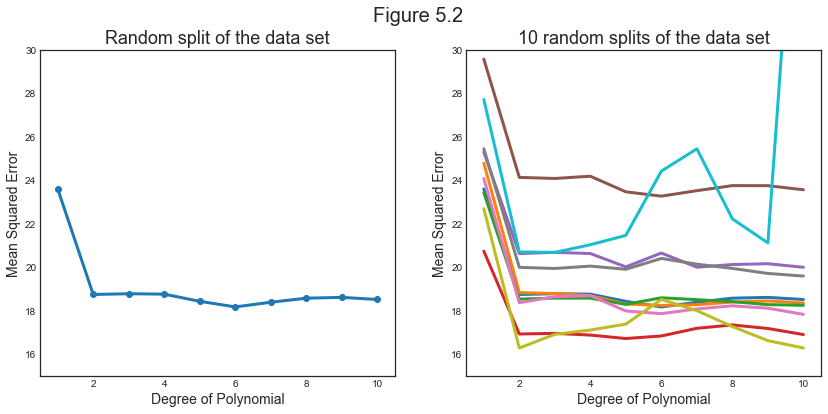

In [8]:
make_figure_5_2()

This figure illustrates a **first drawback** of the validation approach: the estimate of the test error rate can be highly variable, depending on precisely which observations are included in the training set and which observations are included in the validation set.


The **second drawback** of the validation approach is that only a subset of the observations—those that are included in the training set rather than in the validation set—are used to fit the model. Since statistical methods tend to per- form worse when trained on fewer observations, this suggests that the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set.

### Leave-One-Out Cross-Validation

Leave-one-out cross-validation (LOOCV) attempts to address that method’s drawbacks.

Like the validation set approach, LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation $i$ is used for the validation set, and the remaining $n-1$ observations make up the training set. The statistical learning method is fit on the $n−1$ training observations and the MSE is computed using the excluded observation $i$. The procedure is repeated $n$ times, for $i=1,...,n$.

The LOOCV estimate for the test MSE is the average of these $n$ test error estimates:

$$
\mathrm{CV}_{(n)}=\frac{1}{n} \sum_{i=1}^{n} \mathrm{MSE}_{i}
$$

LOOCV has a couple of major **advantages** over the validation set approach. 

First, it has far less bias. In LOOCV, we repeatedly fit the statistical learning method using training sets that contain $n − 1$ observations, almost as many as are in the entire data set. However, this also means that LOOCV is more computationally intense.

Second, in contrast to the validation approach which will yield different results when applied repeatedly due to randomness in the training/validation set splits, performing LOOCV multiple times will always yield the same results: there is no randomness in the training/validation set splits.

In [9]:
# LeaveOneOut CV function for polynomials
def loo_cv_poly(X, y, p_order):
    start = time.time()
    
    # Init
    loo = LeaveOneOut().get_n_splits(y)
    loo_scores = np.zeros((p_order.size,1))
    
    # For every polynomial degree
    for i in p_order:
        # Generate polynomial
        X_poly = PolynomialFeatures(i+1).fit_transform(X)

        # Get score
        loo_scores[i] = cross_val_score(LinearRegression(), X_poly, y, cv=loo, scoring='neg_mean_squared_error').mean()
        
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return loo_scores

Let's compare the validation set approach against LOO in terms of computational time.

In [10]:
# Validation set approach
cv_scores = cv_poly(X, y, p_order, r_states, t_prop)
    
# Leave One Out CV
loo_scores = loo_cv_poly(X, y, p_order)

Time elapsed: 0.0270 seconds
Time elapsed: 1.1495 seconds


As expected, LOOCV is much more computationally intense. Even accounting for the fact that we repeat every the validation set approach 10 times.

Let's now compare them in terms of accuracy in minimizing the MSE.

In [11]:
# Make new figure 1
def make_new_figure_1():

    # Init
    fig, ax = plt.subplots(1,1, figsize=(7,6))

    # Left plot
    ax.plot(p_order+1, np.array(loo_scores)*-1, '-o', label='LOOCV')
    ax.plot(p_order+1, np.mean(cv_scores, axis=1), '-o', c='orange', label='Standard CV')
    ax.set_ylabel('Mean Squared Error'); ax.set_xlabel('Degree of Polynomial');
    ax.set_ylim(15,30); ax.set_xlim(0.5,10.5);
    ax.set_xticks(range(2,11,2));
    ax.legend();

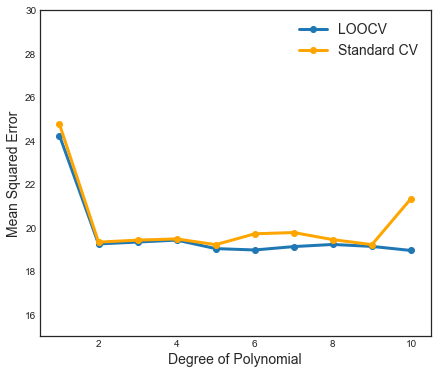

In [12]:
make_new_figure_1()

With least squares linear or polynomial regression, an amazing shortcut makes the cost of LOOCV the same as that of a single model fit! The following formula holds:

$$
\mathrm{CV}_{(n)}=\frac{1}{n} \sum_{i=1}^{n}\left(\frac{y_{i}-\hat{y}_{i}}{1-h_{i}}\right)^{2}
$$

where $\hat y_i$ is the $i^{th}$ fitted value from the original least squares fit, and $h_i$ is the leverage of observation $i$.

### k-Fold Cross-Validation

An alternative to LOOCV is k-fold CV. This approach involves the following steps:

1. Randomly dividing the set of observations into $k$ groups, or folds, of approximately equal size.
2. The first fold is treated as a validation set, and the method is fit on the remaining $k − 1$ folds. 
3. The mean squared error, MSE1, is then computed on the observations in the held-out fold.
4. Steps (1)-(3) are repeated $k$ times; each time, a different group of observations is treated as a validation set.

The k-fold CV estimate is computed by averaging these values

$$
\mathrm{CV}_{(k)}=\frac{1}{k} \sum_{i=1}^{k} \mathrm{MSE}_{i}
$$

LOOCV is a special case of k-fold CV in which $k$ is set to equal $n$. In practice, one typically performs k-fold CV using $k = 5$ or $k = 10$.

The most obvious **advantage** is computational. LOOCV requires fitting the statistical learning method $n$ times, while k-fold CV only requires $k$ splits. 

In [13]:
# 10fold CV function for polynomials
def k10_cv_poly(X, y, p_order, r_states, folds):
    start = time.time()
    
    # Init
    k10_scores = np.zeros((p_order.size,r_states.size))

    # Generate 10 random splits of the dataset
    for j in r_states:

        # For every polynomial degree
        for i in p_order:

            # Generate polynomial
            X_poly = PolynomialFeatures(i+1).fit_transform(X)

            # Split sample in train and test
            kf10 = KFold(n_splits=folds, shuffle=True, random_state=j)
            k10_scores[i,j] = cross_val_score(LinearRegression(), X_poly, y, cv=kf10, 
                                               scoring='neg_mean_squared_error').mean()  
    
    print('Time elapsed: %.4f seconds' % (time.time()-start))
    return k10_scores

Let's now compare 10 fold cross-validation with LOO in terms of computational time.

In [14]:
# Leave One Out CV
loo_scores = loo_cv_poly(X, y, p_order)
    
# 10-fold CV
folds = 10
k10_scores = k10_cv_poly(X, y, p_order, r_states, folds)

Time elapsed: 1.1153 seconds
Time elapsed: 0.3078 seconds


Indeed we see that the LOOCV approach is more computationally intense. Even accounting for the fact that we repeat every 10-fold cross-validation 10 times.

We can now compare all the methods in terms of accuracy.

In [15]:
# Figure 5.4
def make_figure_5_4():

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(17,5))
    fig.suptitle('Figure 5.4')

    # Left plot
    ax1.plot(p_order+1, np.array(loo_scores)*-1, '-o')
    ax1.set_title('LOOCV', fontsize=12)

    # Center plot
    ax2.plot(p_order+1,k10_scores*-1)
    ax2.set_title('10-fold CV', fontsize=12)

    # Right plot
    ax3.plot(p_order+1, np.array(loo_scores)*-1, '-o', label='LOOCV')
    ax3.plot(p_order+1, np.mean(cv_scores, axis=1), label='Standard CV')
    ax3.plot(p_order+1,np.mean(k10_scores,axis=1)*-1, label='10-fold CV')
    ax3.set_title('Comparison', fontsize=12);
    ax3.legend();

    for ax in fig.axes:
        ax.set_ylabel('Mean Squared Error')
        ax.set_ylim(15,30)
        ax.set_xlabel('Degree of Polynomial')
        ax.set_xlim(0.5,10.5)
        ax.set_xticks(range(2,11,2));

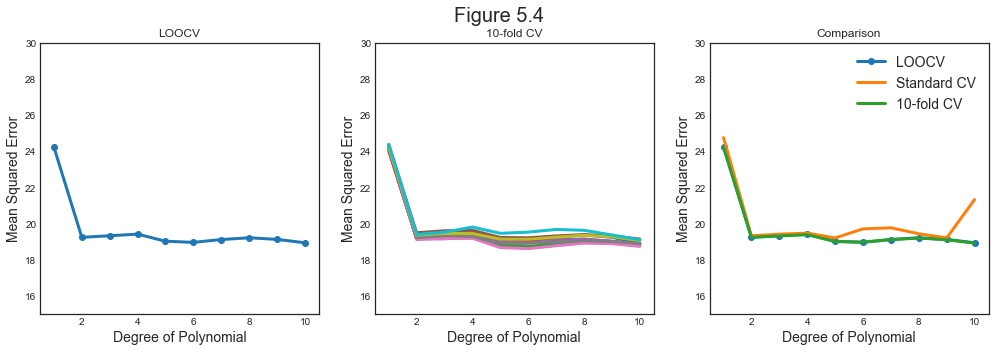

In [16]:
make_figure_5_4()

10-fold cross-validation outputs a very similar MSE with respect to LOOCV, but with considerably less computational time.

## 4.2 The Bootstrap

The bootstrap is a widely applicable and extremely powerful statistical tool that can be used to **quantify the uncertainty** associated with a given estimator or statistical learning method. In the specific case of linear regression, this is not particularly useful since there exist a formula for the standard errors. However, there are many models (almost all actually) for which there exists no closed for solution to the estimator variance.

In pricinple, we would like to draw independent samples from the true data generating process and assessing the uncertainty of an estimator by comparing its values across the different samples. However, this is clearly unfeasible since we do not know the true data generating process.

With the bootstrap, rather than repeatedly obtaining independent data sets from the population, we instead obtain distinct data sets by repeatedly sampling observations from the original data set. The power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.

We are now going to assess its usefulness through simulation. Take the following model:

$$
y_i = \beta_0 \cdot x_i + \varepsilon_i
$$

where $\beta_0 = 0.6$ and $\varepsilon \sim N(0,1)$. We are now going to assess the variance of the OLS estimator $\hat \beta$ with the standard formula, simulating different samples and with bootstrap.

In [17]:
# Set seed
np.random.seed(1)

# Init
simulations = 1000
N = 1000
beta_0 = 0.6
beta_sim = np.zeros((simulations,1))

# Generate X
X = normal(0,3,N).reshape(-1,1)

# Loop over simulations
for i in range(simulations):
    
    # Generate y
    e = normal(0,1,N).reshape(-1,1)
    y = beta_0*X + e
    
    # Estimate beta OLS
    beta_sim[i] = inv(X.T @ X) @ X.T @ y

In [18]:
# Init Bootstrap
beta_boot = np.zeros((simulations,1))

# Loop over simulations
for i in range(simulations):
    
    # Sample y
    X_sample, y_sample = resample(X, y, random_state=i)
    
    # Estimate beta OLS
    beta_boot[i] = inv(X_sample.T @ X_sample) @ X_sample.T @ y_sample

We can first compare the means.

In [19]:
# Print means
print('True value      : %.4f' % beta_0)
print('Mean Simulations: %.4f' % np.mean(beta_sim))
print('Mean One Sample : %.4f' % beta_sim[-1])
print('Mean Boostrap   : %.4f' % np.mean(beta_boot))

True value      : 0.6000
Mean Simulations: 0.6003
Mean One Sample : 0.5815
Mean Boostrap   : 0.5816


The mean of the bootstrap estimtor is quite off. But this is not its actual purpose: it is designed to assess the uncertainty of an estimator, not its value.

Now we compare the variances.

In [20]:
# Print variances
print('True std       : %.6f' % np.sqrt(inv(X.T @ X)))
print('Std Simulations: %.6f' % np.std(beta_sim))
print('Std One Sample : %.6f' % np.sqrt(inv(X.T @ X) * np.var(y - beta_sim[-1]*X)))
print('Std Boostrap   : %.6f' % np.std(beta_boot))

True std       : 0.010737
Std Simulations: 0.010830
Std One Sample : 0.010536
Std Boostrap   : 0.010812


Bootstrap gets as close to the true standard deviation of the estimator as the simulation with the true data generating process. Impressive!

We can now have a visual inspection.

In [21]:
# Figure 5.10
def make_figure_5_10():

    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,6))
    fig.suptitle('Figure 5.10')

    # Left plot
    ax1.hist(beta_sim, bins=10, edgecolor='black');
    ax1.axvline(x=beta_0, color='r', label='beta_0')
    ax1.set_xlabel('beta simulated');

    # Center plot
    ax2.hist(beta_boot, bins=10, color='orange', edgecolor='black');
    ax2.axvline(x=beta_0, color='r', label='beta_0')
    ax2.set_xlabel('beta bootstrap');

    # Right plot
    df_bootstrap = pd.DataFrame({'simulated': beta_sim.ravel(), 'bootstrap':beta_boot.ravel()}, 
                                index=range(simulations))
    ax3 = sns.boxplot(data=df_bootstrap, width=0.5, linewidth=2);
    ax3.axhline(y=beta_0, color='r', label='beta_0');

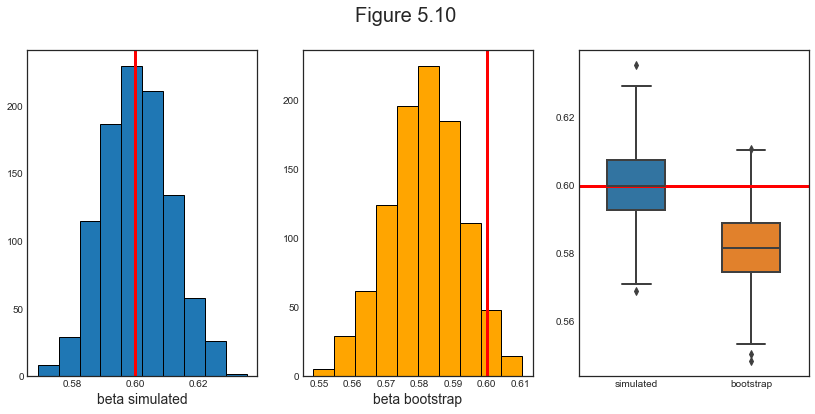

In [22]:
make_figure_5_10()

As we can see, the bootstrap is a powerful tool to assess the uncertainty of an estimator.